# COVID 19: Forecasting using ARIMA and LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

## Data Sources

In [3]:
confirmed_df = pd.read_csv("data/confirmed_df.csv", parse_dates=["Date"])
deaths_df = pd.read_csv("data/deaths_df.csv", parse_dates=["Date"])
recovered_df = pd.read_csv("data/recovered_df.csv", parse_dates=["Date"])

<IPython.core.display.Javascript object>

In [4]:
# Dropping Serial Number
confirmed_df.drop(["SNo"], axis=1, inplace=True)
deaths_df.drop(["SNo"], axis=1, inplace=True)
recovered_df.drop(["SNo"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [5]:
confirmed_df.head()

,Date,Province/State,Country,Confirmed
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,1.0
2,2020-01-22,Anhui,Mainland China,1.0
3,2020-01-22,Beijing,Mainland China,14.0
4,2020-01-22,Chongqing,Mainland China,6.0


<IPython.core.display.Javascript object>

In [6]:
deaths_df.head()

,Date,Province/State,Country,Deaths
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


<IPython.core.display.Javascript object>

In [7]:
recovered_df.head()

,Date,Province/State,Country,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0
1,2020-01-22,Macau,Macau,0.0
2,2020-01-22,Anhui,Mainland China,0.0
3,2020-01-22,Beijing,Mainland China,0.0
4,2020-01-22,Chongqing,Mainland China,0.0


<IPython.core.display.Javascript object>

In [8]:
confirmed_world_df = (
    confirmed_df.groupby("Date")["Confirmed"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [9]:
recovered_world_df = (
    recovered_df.groupby("Date")["Recovered"]
    .sum()
    .sort_values(axis="index")
    .reset_index()
)

<IPython.core.display.Javascript object>

In [10]:
deaths_world_df = (
    deaths_df.groupby("Date")["Deaths"].sum().sort_values(axis="index").reset_index()
)

<IPython.core.display.Javascript object>

## LSTM

In [11]:
look_back = 1
scaler = MinMaxScaler(feature_range=(0, 1))

<IPython.core.display.Javascript object>

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

<IPython.core.display.Javascript object>

In [13]:
def normalize_split(dataset):
    # normalize the dataset
    dataset = scaler.fit_transform(dataset)

    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY

<IPython.core.display.Javascript object>

### Confirmed

In [14]:
(
    confirmed_train_X,
    confirmed_train_Y,
    confirmed_test_X,
    confirmed_test_Y,
) = normalize_split(confirmed_world_df[["Confirmed"]])

<IPython.core.display.Javascript object>

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(confirmed_train_X, confirmed_train_Y, epochs=100, batch_size=1, verbose=0)

<IPython.core.display.Javascript object>

In [16]:
# make predictions
confirmed_train_predict = model.predict(confirmed_train_X)
confirmed_test_predict = model.predict(confirmed_test_X)

# invert predictions
confirmed_train_predict = scaler.inverse_transform(confirmed_train_predict)
confirmed_train_Y = scaler.inverse_transform([confirmed_train_Y])
confirmed_test_predict = scaler.inverse_transform(confirmed_test_predict)
confirmed_test_Y = scaler.inverse_transform([confirmed_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(confirmed_train_Y[0], confirmed_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(confirmed_test_Y[0], confirmed_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 83282.03 RMSE
Test Score: 2002083.16 RMSE


<IPython.core.display.Javascript object>

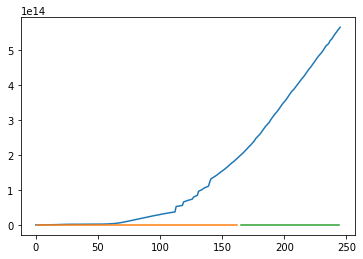

<IPython.core.display.Javascript object>

In [17]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(confirmed_world_df[["Confirmed"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(confirmed_train_predict) + look_back, :
] = confirmed_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(confirmed_world_df[["Confirmed"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(confirmed_train_predict)
    + (look_back * 2)
    + 1 : len(confirmed_world_df[["Confirmed"]])
    - 1,
    :,
] = confirmed_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(confirmed_world_df[["Confirmed"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Recovered (world)

In [18]:
(
    recovered_train_X,
    recovered_train_Y,
    recovered_test_X,
    recovered_test_Y,
) = normalize_split(recovered_world_df[["Recovered"]])

<IPython.core.display.Javascript object>

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(recovered_train_X, recovered_train_Y, epochs=100, batch_size=1, verbose=0)

<IPython.core.display.Javascript object>

In [20]:
# make predictions
recovered_train_predict = model.predict(recovered_train_X)
recovered_test_predict = model.predict(recovered_test_X)

# invert predictions
recovered_train_predict = scaler.inverse_transform(recovered_train_predict)
recovered_train_Y = scaler.inverse_transform([recovered_train_Y])
recovered_test_predict = scaler.inverse_transform(recovered_test_predict)
recovered_test_Y = scaler.inverse_transform([recovered_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(recovered_train_Y[0], recovered_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(
    mean_squared_error(recovered_test_Y[0], recovered_test_predict[:, 0])
)
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 43376.54 RMSE
Test Score: 1333910.83 RMSE


<IPython.core.display.Javascript object>

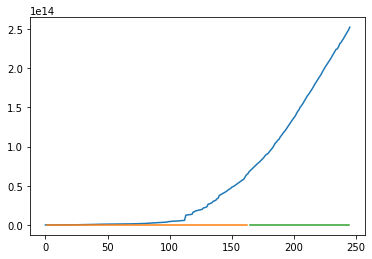

<IPython.core.display.Javascript object>

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(recovered_world_df[["Recovered"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(recovered_train_predict) + look_back, :
] = recovered_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(recovered_world_df[["Recovered"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(recovered_train_predict)
    + (look_back * 2)
    + 1 : len(recovered_world_df[["Recovered"]])
    - 1,
    :,
] = recovered_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(recovered_world_df[["Recovered"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Deaths (world)

In [22]:
(
    deaths_train_X,
    deaths_train_Y,
    deaths_test_X,
    deaths_test_Y,
) = normalize_split(deaths_world_df[["Deaths"]])

<IPython.core.display.Javascript object>

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(deaths_train_X, deaths_train_Y, epochs=100, batch_size=1, verbose=0)

<IPython.core.display.Javascript object>

In [24]:
# make predictions
deaths_train_predict = model.predict(deaths_train_X)
deaths_test_predict = model.predict(deaths_test_X)

# invert predictions
deaths_train_predict = scaler.inverse_transform(deaths_train_predict)
deaths_train_Y = scaler.inverse_transform([deaths_train_Y])
deaths_test_predict = scaler.inverse_transform(deaths_test_predict)
deaths_test_Y = scaler.inverse_transform([deaths_test_Y])

# calculate root mean squared error
trainScore = math.sqrt(
    mean_squared_error(deaths_train_Y[0], deaths_train_predict[:, 0])
)
print("Train Score: %.2f RMSE" % (trainScore))
testScore = math.sqrt(mean_squared_error(deaths_test_Y[0], deaths_test_predict[:, 0]))
print("Test Score: %.2f RMSE" % (testScore))

Train Score: 6726.62 RMSE
Test Score: 49211.66 RMSE


<IPython.core.display.Javascript object>

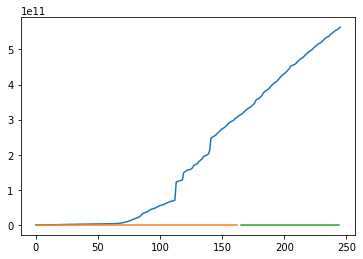

<IPython.core.display.Javascript object>

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(deaths_world_df[["Deaths"]])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[
    look_back : len(deaths_train_predict) + look_back, :
] = deaths_train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(deaths_world_df[["Deaths"]])
testPredictPlot[:, :] = np.nan
testPredictPlot[
    len(deaths_train_predict)
    + (look_back * 2)
    + 1 : len(deaths_world_df[["Deaths"]])
    - 1,
    :,
] = deaths_test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(deaths_world_df[["Deaths"]]))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## ARIMA

### Confirmed

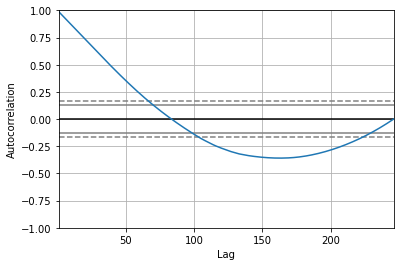

<IPython.core.display.Javascript object>

In [26]:
X = confirmed_world_df[["Confirmed"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3087.664
Method:                       css-mle   S.D. of innovations          71780.117
Date:                Thu, 29 Oct 2020   AIC                           6189.328
Time:                        00:27:01   BIC                           6213.837
Sample:                             1   HQIC                          6199.198
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.698e+04   3.16e+04      3.065      0.002     3.5e+04    1.59e+05
ar.L1.D.y      0.2762      0.063      4.376      0.000       0.152       0.400
ar.L2.D.y      0.1250      0.064      1.958      0.0

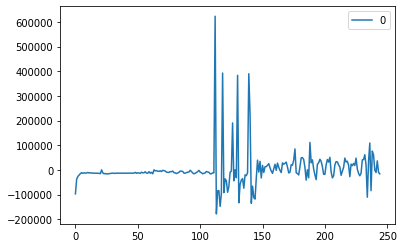

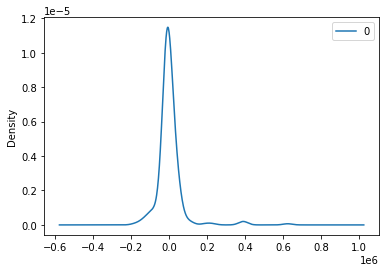

                   0
count     245.000000
mean     1360.554507
std     72060.819809
min   -178248.605445
25%    -13881.117121
50%    -10440.425471
75%     12047.784606
max    623317.634098


<IPython.core.display.Javascript object>

In [27]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [28]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test RMSE: %.3f" % error)

Test RMSE: 44780.586


<IPython.core.display.Javascript object>

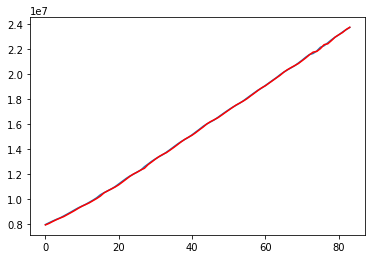

<IPython.core.display.Javascript object>

In [29]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

### Recovered

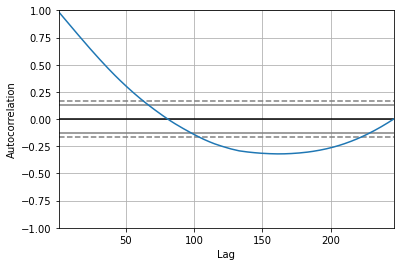

<IPython.core.display.Javascript object>

In [30]:
X = recovered_world_df[["Recovered"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2955.226
Method:                       css-mle   S.D. of innovations          41731.814
Date:                Thu, 29 Oct 2020   AIC                           5924.452
Time:                        00:27:15   BIC                           5948.960
Sample:                             1   HQIC                          5934.321
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.483e+04   3.99e+04      1.626      0.104   -1.33e+04    1.43e+05
ar.L1.D.y      0.1355      0.063      2.159      0.031       0.013       0.258
ar.L2.D.y      0.1924      0.062      3.123      0.0

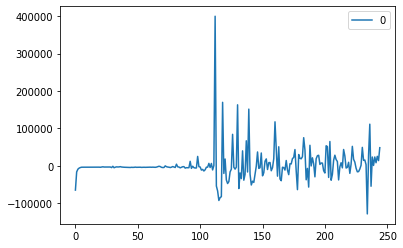

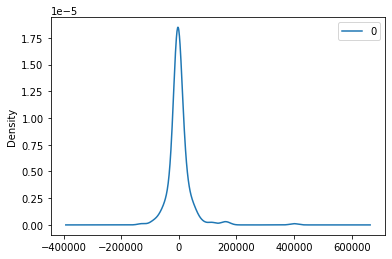

                   0
count     245.000000
mean     1891.235404
std     41927.589561
min   -128529.329325
25%     -6272.309103
50%     -3553.278648
75%      7306.785931
max    400021.081381


<IPython.core.display.Javascript object>

In [31]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [32]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test Root MSE: %.3f" % error)

Test Root MSE: 37252.975


<IPython.core.display.Javascript object>

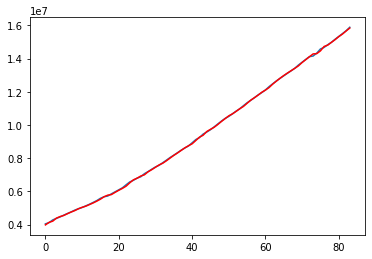

<IPython.core.display.Javascript object>

In [33]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

### Deaths

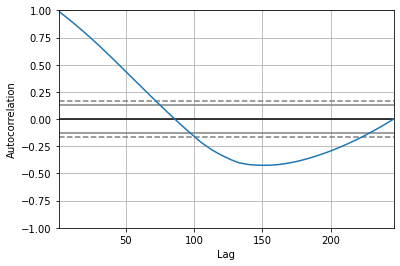

<IPython.core.display.Javascript object>

In [34]:
X = deaths_world_df[["Deaths"]].values

autocorrelation_plot(X)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  245
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2462.193
Method:                       css-mle   S.D. of innovations           5601.136
Date:                Thu, 29 Oct 2020   AIC                           4938.386
Time:                        00:27:36   BIC                           4962.895
Sample:                             1   HQIC                          4948.256
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3053.6096    492.988      6.194      0.000    2087.371    4019.849
ar.L1.D.y      0.1316      0.064      2.068      0.039       0.007       0.256
ar.L2.D.y      0.0460      0.064      0.718      0.4

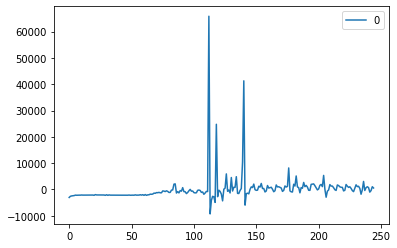

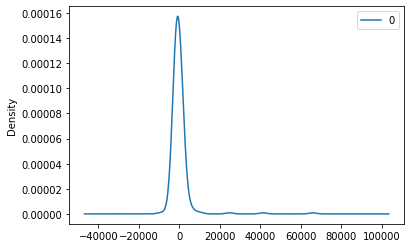

                  0
count    245.000000
mean       8.962320
std     5612.742152
min    -9308.081812
25%    -2118.187379
50%     -668.993227
75%      710.596911
max    65831.673674


<IPython.core.display.Javascript object>

In [35]:
# fit model
model = ARIMA(X, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind="kde")
plt.show()
print(residuals.describe())

In [36]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size : len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
error = mean_squared_error(test, predictions, squared=False)
print("Test Root MSE: %.3f" % error)

Test Root MSE: 1772.175


<IPython.core.display.Javascript object>

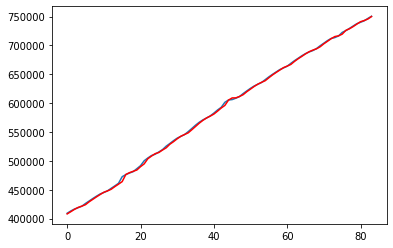

<IPython.core.display.Javascript object>

In [37]:
# plot
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

## References

1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
2. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/